In [34]:
# 添加库函数
import os
import torch
import torch.nn as nn
import math
import torch.optim as optim
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,OrthographicCameras
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
from torch.autograd import gradcheck

import plotly.graph_objects as go

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(90, 90)
    ax.axis('equal')
    plt.show()

def plot_pointclouds_rotation(mesh, title = ""):
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    # 创建 3D 图形
    fig = go.Figure(data=[go.Scatter3d(
        x=x, 
        y=y, 
        z=z, 
        mode='markers',
        marker=dict(
            size=2  # 设置点的大小
        )
    )])

    # 更新布局
    fig.update_layout(scene=dict(
        xaxis_title='X轴',
        yaxis_title='Y轴',
        zaxis_title='Z轴'
    ))

    # 显示图形
    fig.show()

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [35]:
# 载入一个模型
trg_obj = 'Geographos Radar-based, low-res(1).obj'
# trg_obj = 'wx_origin.obj'

# trg_obj = 'dolphin.obj'
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])


# 为mesh添加材质信息
verts_rgb = torch.ones_like(trg_mesh.verts_packed())*255  # 使用纯白色作为默认颜色
verts_rgb = verts_rgb.unsqueeze(0)
textures = TexturesVertex(verts_features=verts_rgb)
trg_mesh.textures = textures
src_mesh = trg_mesh

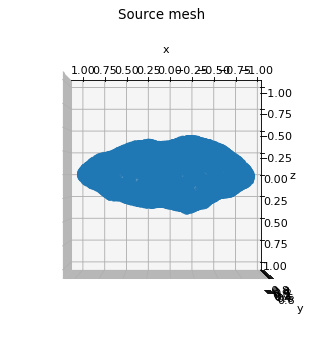

In [36]:
# # 创建初始模型，球形
# sphere1 = ico_sphere(4, device)
# sphere2 = ico_sphere(4, device)

# # 平移第二个球体，使它与第一个球体黏连
# # 获取第一个球体的最大 x 坐标
# max_x = sphere1.verts_packed()[:, 0].max()

# # 获取第二个球体的顶点并进行x方向平移
# shift = max_x - 0.1  # 确保轻微重叠
# verts2 = sphere2.verts_packed() + torch.tensor([shift, 0, 0], device=device)

# # 获取第一个球体的顶点并且平移
# verts1 = sphere2.verts_packed() + torch.tensor([-shift, 0, 0], device=device)

# # 合并两球体的顶点
# verts = torch.cat([verts1, verts2], dim=0)

# # 将两球质点平移
# verts = verts + torch.tensor([0, 0, 0.8], device=device)

# # 合并面片，并更新第二个球体的面片索引
# faces1 = sphere1.faces_packed()
# faces2 = sphere2.faces_packed() + sphere1.verts_packed().shape[0]  # 更新索引

# # 合并面片数据
# faces = torch.cat([faces1, faces2], dim=0)

# # 创建黏连的球体网格
# src_mesh = Meshes(verts=[verts], faces=[faces])


# verts = src_mesh.verts_packed()
# faces = src_mesh.faces_packed()
# scaled_verts = verts * 0.5

# src_mesh = Meshes(verts=[scaled_verts], faces=[faces])

# 绘制初始情况下的src_mesh
plot_pointcloud(src_mesh, "Source mesh")
trg_mesh = src_mesh

In [37]:
# # 创建一个球
# trg_mesh = ico_sphere(4, device)
# verts = trg_mesh.verts_packed()
# faces = trg_mesh.faces_packed()
# scaled_verts = verts * 0.5

# # 将两球质点平移
# scaled_verts = scaled_verts + torch.tensor([0, 0, 0.4], device=device)

# trg_mesh = Meshes(verts=[scaled_verts], faces=[faces])

# # 绘制初始情况下的src_mesh
# plot_pointcloud(trg_mesh, "Source mesh")
# 创建一个球


In [38]:
# print(trg_mesh.faces_packed().shape[0])

In [44]:
# 输入大小为[1,3]初始向量vec，大小分别为[1]旋转轴axis_x,axis_y,axis_z，大小为[num,1]的旋转角度theta，输出大小为[num,3]的旋转后向量
def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot

# batchsize
batch = 30
# 雷达视线方向1
RadarLos = torch.tensor([0,0,-1.0], device=device)
theta = torch.linspace(0,2*math.pi,batch).to(device)

axis_x = torch.tensor([0.0], device=device)
axis_y = torch.tensor([1.0], device=device)
axis_z = torch.tensor([0.0], device=device)

# # 雷达视线方向2
# RadarLos = torch.tensor([0,math.sqrt(3)/2,-1/2], device=device)
# theta = torch.linspace(0,2*math.pi,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([1.0], device=device)
# axis_z = torch.tensor([0.0], device=device)

# Round_radar_los = vec_rot(RadarLos,axis_x,axis_y,axis_z,-theta)

# # 雷达视线方向3
# RadarLos = torch.tensor([0,-math.sqrt(3)/2,-1/2], device=device)
# theta = torch.linspace(0,2*math.pi,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([1.0], device=device)
# axis_z = torch.tensor([0.0], device=device)

# # 雷达视线方向4
# RadarLos = torch.tensor([0,0,-1.0], device=device)
# theta = torch.linspace(0,2*math.pi,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([math.sqrt(3)/2], device=device)
# axis_z = torch.tensor([1/2], device=device)

# # 雷达视线方向5
# RadarLos = torch.tensor([0,0,-1.0], device=device)
# theta = torch.linspace(0,2*math.pi,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([math.sqrt(3)/2], device=device)
# axis_z = torch.tensor([-1/2], device=device)

Round_radar_los = vec_rot(RadarLos,axis_x,axis_y,axis_z,-theta)
Round_radar_los_real = vec_rot(RadarLos,axis_x,axis_y,axis_z,theta)

# # 打印雷达视线方向
# print(Round_radar_los)
# 可视化雷达视线方向
radar_los_numpy = Round_radar_los.detach().cpu().numpy()

fig = go.Figure(data=[go.Scatter3d(
    x=radar_los_numpy[:,0], 
    y=radar_los_numpy[:,1], 
    z=radar_los_numpy[:,2], 
    mode='markers',
    marker=dict(
        size=2  # 设置点的大小
    )
)])

# 更新布局
fig.update_layout(scene=dict(
    xaxis_title='X轴',
    yaxis_title='Y轴',
    zaxis_title='Z轴'
))

# 显示图形
fig.show()


tensor([[ 0.0000e+00,  0.0000e+00, -1.0000e+00],
        [ 2.1497e-01,  0.0000e+00, -9.7662e-01],
        [ 4.1989e-01,  0.0000e+00, -9.0758e-01],
        [ 6.0517e-01,  0.0000e+00, -7.9609e-01],
        [ 7.6216e-01,  0.0000e+00, -6.4739e-01],
        [ 8.8351e-01,  0.0000e+00, -4.6841e-01],
        [ 9.6355e-01,  0.0000e+00, -2.6753e-01],
        [ 9.9853e-01,  0.0000e+00, -5.4139e-02],
        [ 9.8683e-01,  0.0000e+00,  1.6178e-01],
        [ 9.2898e-01,  0.0000e+00,  3.7014e-01],
        [ 8.2769e-01,  0.0000e+00,  5.6119e-01],
        [ 6.8770e-01,  0.0000e+00,  7.2600e-01],
        [ 5.1555e-01,  0.0000e+00,  8.5686e-01],
        [ 3.1930e-01,  0.0000e+00,  9.4765e-01],
        [ 1.0812e-01,  0.0000e+00,  9.9414e-01],
        [-1.0812e-01,  0.0000e+00,  9.9414e-01],
        [-3.1930e-01,  0.0000e+00,  9.4765e-01],
        [-5.1555e-01,  0.0000e+00,  8.5686e-01],
        [-6.8770e-01,  0.0000e+00,  7.2600e-01],
        [-8.2769e-01,  0.0000e+00,  5.6119e-01],
        [-9.2898e-01

In [45]:
# 制造可视化模型
class visible_mesh(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()
        self.device = device

    def forward(self,mesh,RadarLos):
        batch = RadarLos.shape[0]
        face_num = mesh.faces_packed().shape[0]
        face_mask = torch.zeros((batch,face_num),dtype=bool,device=self.device)
        # 计算由函数look_at_view_transform得到的旋转矩阵和平移矩阵
        at = torch.tensor([0.0, 0.0, 0.0], device=device).expand(Round_radar_los.shape)
        up = torch.tensor([0.0, 1.0, 0.0], device=device).expand(Round_radar_los.shape)

        R, T = look_at_view_transform(eye=Round_radar_los*3, at=at, up=up)
        # 生成渲染器
        raster_settings = RasterizationSettings(
            image_size=1024, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
        )
        # 生成相机
        cameras = OrthographicCameras(device=self.device, R=R, T=T)
        # 生成栅格化器
        rasterizer = MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        )
        fragments = rasterizer(mesh.extend(batch))
        # 在并行处理时，一个batch中的不同mesh有不同的面标识，但这些面标识有规律的从小到大排列,因此可以直接Unique
        p2f = fragments.pix_to_face
        p2f_mask = p2f[p2f>=0]
        p2f_mask_unique = torch.unique(p2f_mask)
        face_mask = face_mask.view(-1)
        face_mask[p2f_mask_unique] = True
        face_mask = face_mask.view(batch,-1)

        all_faces = mesh.faces_packed()
        all_verts = mesh.verts_packed() 
        # 利用面掩码生成批次索引
        batch_size, num_faces = face_mask.shape
        faces_batch = [all_faces[m] for m in face_mask]
        verts_batch = [all_verts] * batch_size  # 假设每个 batch 使用同样的顶点
        # 直接创建 Meshes 对象
        Meshes_new = Meshes(verts=verts_batch, faces=faces_batch)


        return Meshes_new
    

visible_mesh1 = visible_mesh(device)
Meshes_new = visible_mesh1(trg_mesh,Round_radar_los)


# faces = trg_mesh.faces_packed()[face_mask[6,:]]
# verts = trg_mesh.verts_packed()

# Meshes_new = Meshes(verts=[verts], faces=[faces])



# plot_pointclouds_rotation(Meshes_new[7])
# plot_pointclouds_rotation(Meshes_new[9])
# plot_pointclouds_rotation(Meshes_new[11])


In [50]:
# 获得相机位置和视线位置对应的旋转矩阵

def get_normals(meshes):
    verts_packed = meshes.verts_packed()  # (V, 3)
    faces_packed = meshes.faces_packed()  # (F, 3)

    # 获取每个面的顶点
    faces_verts = verts_packed[faces_packed]  # (F, 3, 3)

    # 计算叉乘，获取法向量
    face_normals = torch.cross(
        faces_verts[:, 1] - faces_verts[:, 0],
        faces_verts[:, 2] - faces_verts[:, 0],
        dim=1
    )

    # 归一化法向量
    face_normals = face_normals / (face_normals.norm(dim=1, keepdim=True) + 1e-6)

    # face_normals 现在是每个面的法向量
    return face_normals

def rr2rd(meshes, doppler_vec, dopplercoefficient):
    verts_list = meshes.verts_list()
    faces_list = meshes.faces_list()
    # 将dopplercorfficient转换为list
    dopplercoefficient = dopplercoefficient.tolist()

    # 确保 doppler_vec 的长度等于 verts_list 的长度
    if len(doppler_vec) != len(verts_list):
        raise ValueError("Length of doppler_vec must match number of vertex lists")
    # print(doppler_vec)
    # print(verts_list.shape)
    projection_list = [
        (verts @ doppler_vec[i].unsqueeze(1)) * doppler_vec[i].unsqueeze(1).T
        for i, verts in enumerate(verts_list)
    ]
    
    scaled_projection = [proj * coefficient for proj,coefficient in zip(projection_list,dopplercoefficient)]
    scaled_verts_list = [verts + (scaled - proj) for verts, scaled, proj in zip(verts_list, scaled_projection, projection_list)]

    # 创建新的 Meshes 对象
    meshes_scaled = Meshes(verts=scaled_verts_list, faces=faces_list)

    return meshes_scaled

def angel2vec(ele,azi):
    elev_rad = torch.deg2rad(ele)
    azim_rad = torch.deg2rad(azi)
    
    direction_vector = torch.stack([
        torch.cos(elev_rad) * torch.sin(azim_rad),
        torch.sin(elev_rad),
        torch.cos(elev_rad) * torch.cos(azim_rad)
    ],dim=-1)

    return direction_vector

class mesh_radar_render(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()
        self.device = device
    
    def forward(self,meshes,radarlos,omega_vec,omega,dopplercoefficient):

        # 输入为 mesh [batch]
        # radarele [batch]
        # radarazi [batch]
        # omegaele [batch]
        # omegaazi [batch]
        # omega [batch]

        # from opts import config_parser
        # parser = config_parser()
        # args = parser.parse_args()

        # 多普勒轴
        doppler_vec = torch.linalg.cross(radarlos,omega_vec)
        # 对doppler_vec进行归一化
        doppler_vec = doppler_vec / (torch.linalg.norm(doppler_vec,dim=-1).unsqueeze(-1) + 1e-6)
        print(radarlos[0])
        print(omega_vec[0])
        print(doppler_vec[0])
        # 生成成像方向
        image_vec = torch.linalg.cross(radarlos,doppler_vec)
        # print(image_vec.shape)
        # print(image_vec)
        # 将Image——vec向量可视化
        image_vec_numpy = image_vec.detach().cpu().numpy()
        for i in range(image_vec_numpy.shape[0]):
            fig.add_trace(go.Scatter3d(
                x=[0, image_vec_numpy[i,0]],
                y=[0, image_vec_numpy[i,1]],
                z=[0, image_vec_numpy[i,2]],
                mode='lines+markers',
                marker=dict(size=4),
                line=dict(width=5)
            ))
        # # 将omega_vec向量可视化
        # omega_vec_numpy = omega_vec.detach().cpu().numpy()
        # for i in range(omega_vec_numpy.shape[0]):
        #     fig.add_trace(go.Scatter3d(
        #         x=[0, omega_vec_numpy[i,0]],
        #         y=[0, omega_vec_numpy[i,1]],
        #         z=[0, omega_vec_numpy[i,2]],
        #         mode='lines+markers',
        #         marker=dict(size=4),
        #         line=dict(width=5)
        #     ))
        # # 将doppler_vec向量可视化
        # doppler_vec_numpy = doppler_vec.detach().cpu().numpy()
        # for i in range(doppler_vec_numpy.shape[0]):
        #     fig.add_trace(go.Scatter3d(
        #         x=[0, doppler_vec_numpy[i,0]],
        #         y=[0, doppler_vec_numpy[i,1]],
        #         z=[0, doppler_vec_numpy[i,2]],
        #         mode='lines+markers',
        #         marker=dict(size=4),
        #         line=dict(width=5)
        #     ))
        # # 更新布局
        # fig.update_layout(scene=dict(
        #     xaxis_title='X轴',
        #     yaxis_title='Y轴',
        #     zaxis_title='Z轴'
        # ))

        # # 将坐标轴设置为相等
        # fig.update_layout(scene_aspectmode='cube')

        # # 显示图形
        # fig.show()
        # 计算由函数look_at_view_transform得到的旋转矩阵和平移矩阵
        at = torch.tensor([0.0, 0.0, 0.0], device=device).expand(Round_radar_los.shape)

        R, T = look_at_view_transform(eye=image_vec*3, at=at, up=radarlos)
        cameras = OrthographicCameras(device=device, R=R, T=T)
        # 获得法向量
        normals = get_normals(meshes)
        # 对mesh进行变换到多普勒域
        meshes_scaled = rr2rd(meshes,doppler_vec,dopplercoefficient)
        # 渲染
        raster_settings = RasterizationSettings(
            image_size=(100,100), 
            blur_radius=0, 
            faces_per_pixel=3,
        )
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )
        fragments = rasterizer(meshes_scaled)
        # print(fragments.pix_to_face.shape)
        # print(fragments.pix_to_face[0,50,:,:])
        zero_vector = torch.zeros(1, 3, device=self.device)
        normal_batch = torch.where(
            fragments.pix_to_face[...,None] == -1,                      # 添加维度适配零向量
            zero_vector,                               # 用零向量替换不合法的索引
            normals[fragments.pix_to_face.clamp_min(0)]                  # 使用 torch.clamp_min 防止负值索引
        )
        image = torch.sum(normal_batch*radarlos.unsqueeze(1).unsqueeze(2).unsqueeze(3),dim=-1)
        # 删除image中的所有负值
        image = torch.nn.functional.relu(image)
        image = torch.sum(image,dim = -1)

        return image

def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot

# 转轴
omega_vec = torch.tensor([0.0,1.0,0.0],device=device).expand(Round_radar_los.shape)
# 转速
omega = torch.tensor([1.0],device=device).expand(Round_radar_los.shape[0])
# omega = torch.tensor([1],device=device).expand(Round_radar_los.shape[0])
# 雷达视线方向与转轴的夹角
theta_los_omega = torch.linalg.cross(Round_radar_los,omega_vec)
# 计算夹角的正弦值
sin_theta_los_omega = torch.linalg.norm(theta_los_omega,dim=-1)
# 多普勒距离维系数
lambda1 = torch.tensor([2.0],device=device)
dopplercoefficient = 2*omega/lambda1*sin_theta_los_omega
# dopplercoefficient = torch.tensor([1.0],device=device).expand(Round_radar_los.shape[0])
mesh_radar_render1 = mesh_radar_render(device)
image = mesh_radar_render1(Meshes_new,Round_radar_los,omega_vec,omega,dopplercoefficient)     
# 添加噪声
# noise = torch.rand_like(image)
# noise = torch.sqrt(-0.5 * torch.log(noise))
# image = image + noise

image = torch.rot90(image,k=1,dims=(1,2))
# plt.figure()
# plt.imshow(image[0,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[3,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[6,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[9,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[12,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[15,:,:].squeeze(0).detach().cpu(),cmap='hot')

# 将图片转换为numpy,并保存为png文件
image_max = image.max().detach().cpu().numpy()
# print(image_max)
image_min = image.min().detach().cpu().numpy()
import cv2
import numpy as np
filename = './ISAR_NERF/asteroid_image_nerf_new/task3'
if not os.path.exists(filename):
    print("创建文件夹")
    os.makedirs(filename)
for i in range(0,30):
    image_i = image[i,:,:].squeeze(0).detach().cpu().numpy()
    image_i = (image_i - image_min)/(image_max-image_min)
    LOS_real = Round_radar_los_real[i].detach().cpu().numpy()
    rotation_axis = omega_vec[i].detach().cpu().numpy()

    np.savez(filename+'/image'+str(i+60)+".npz", image=image_i, LOS = LOS_real, rotation_axis = rotation_axis)
    image_i = np.uint8(image_i*255)
    cv2.imwrite(filename+'/image'+str(i+60)+".png",image_i)

# # 记录实验参数
# import logging

# # 配置日志记录
# logging.basicConfig(filename='experiment.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# def log_experiment_params(params):
#     logging.info(f'实验参数: {params}')

# # 示例实验参数
# experiment_params = {
#     'experiment_name': 'ISAR_NERF_30*3image',
#     'target_name': trg_obj,
#     ''
# }

# # 记录实验参数
# log_experiment_params(experiment_params)

tensor([ 0.,  0., -1.], device='cuda:3')
tensor([0., 1., 0.], device='cuda:3')
tensor([1.0000, -0.0000, 0.0000], device='cuda:3')
创建文件夹


In [7]:
image_batch = np.load('./2024wb_new/2024wb.npz')
image_input = image_batch['image_batch']
image_trg = np.abs(image_input)

plt.imshow(image_trg[0,:,:],cmap='hot')
image_trg = torch.tensor([image_trg],device=device)
image_trg = image_trg.squeeze(0)
# 数据归一化
max_values, _ = torch.max(image_trg, dim=2)
max_values_dim1, _ = torch.max(max_values, dim=1)
image_trg = image_trg/max_values_dim1.unsqueeze(1).unsqueeze(2)

FileNotFoundError: [Errno 2] No such file or directory: './2024wb_new/2024wb.npz'

  0%|          | 0/4000 [00:00<?, ?it/s]

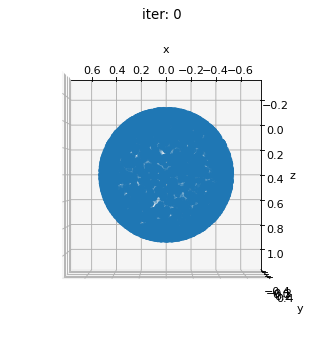

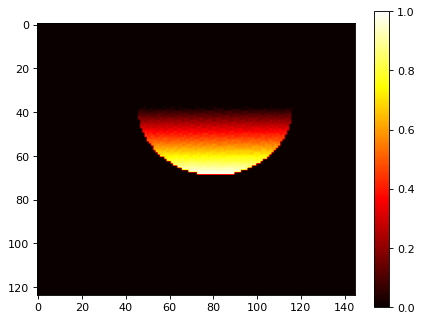

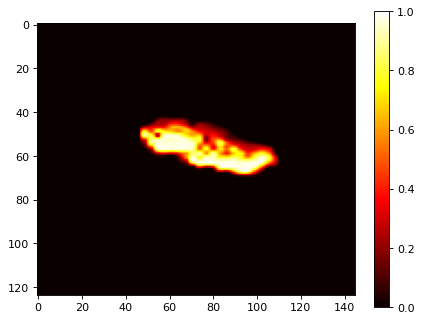

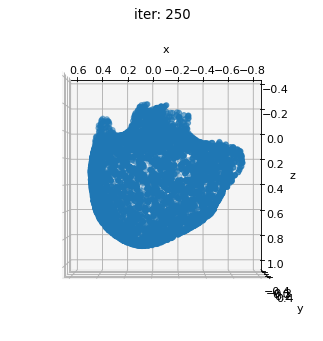

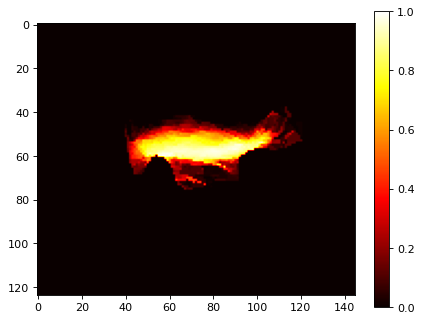

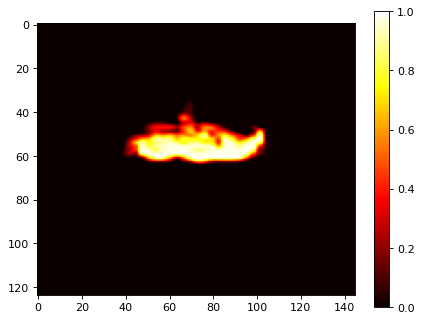

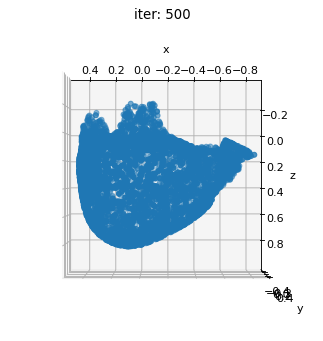

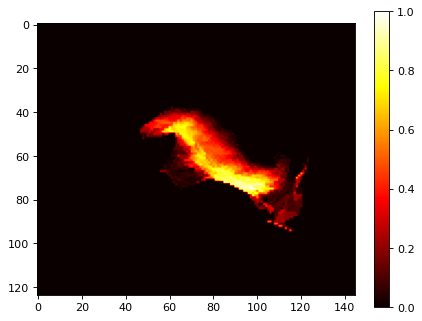

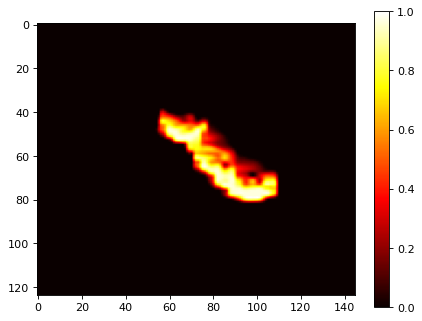

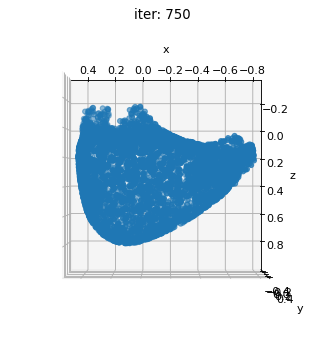

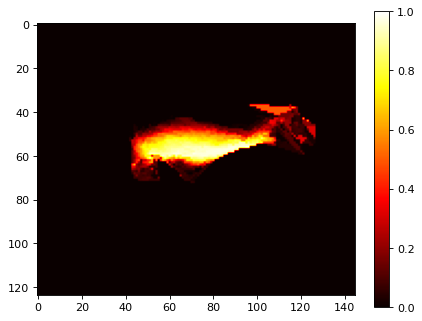

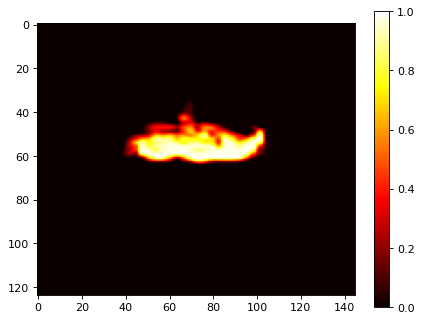

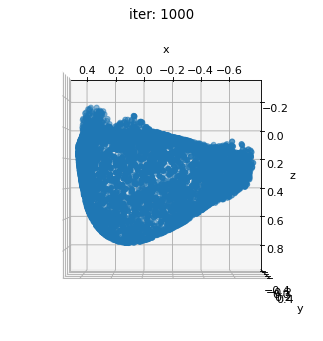

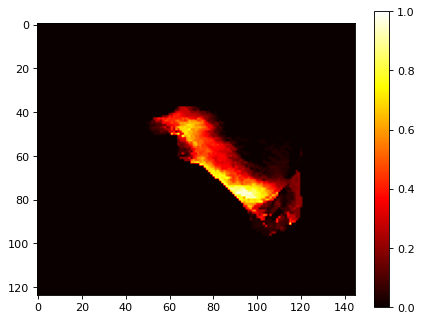

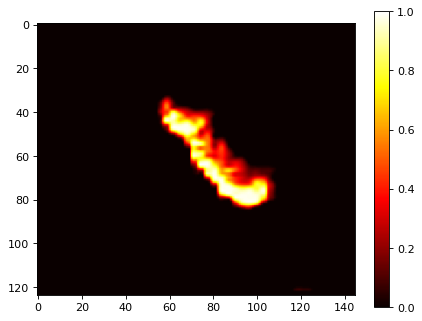

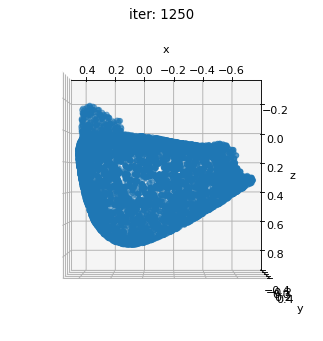

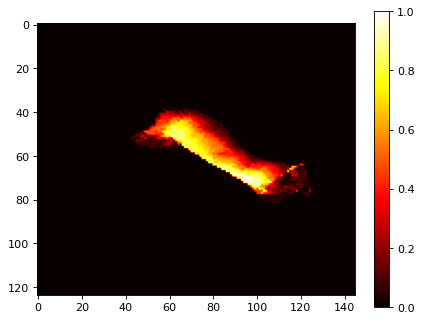

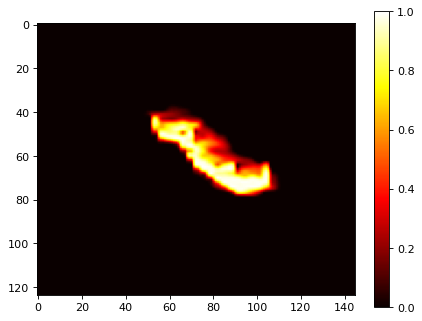

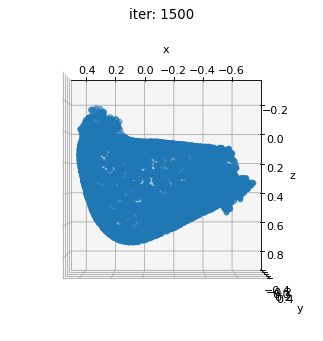

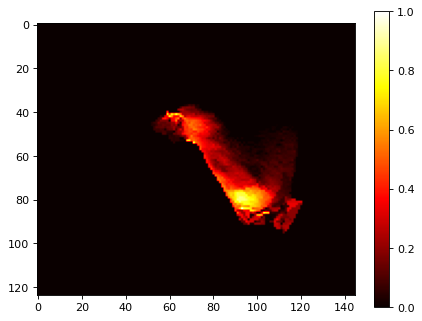

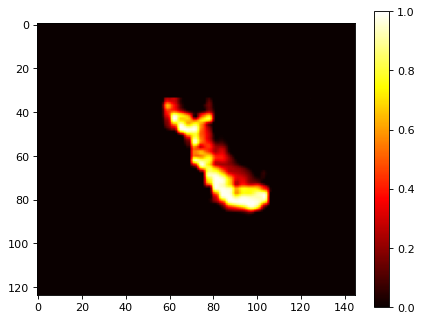

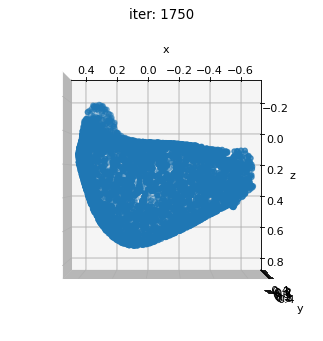

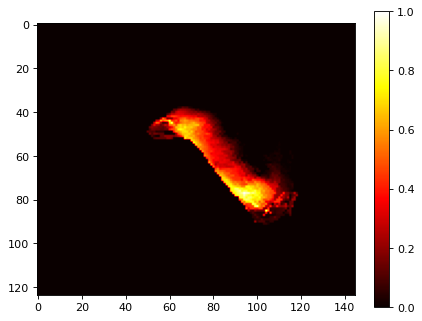

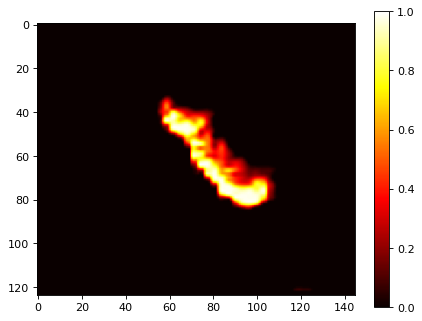

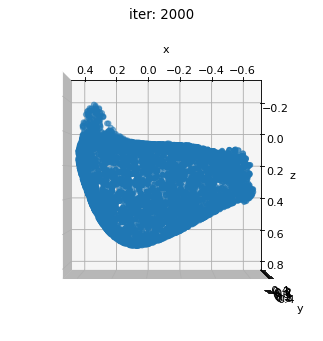

In [ ]:
deform_verts = torch.full(trg_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.Adam([deform_verts], lr=0.005)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4000,eta_min=5e-4)


# Number of optimization steps
Niter = 4000
# Weight for the image loss
w_image = 0.001
# Weight for mesh edge loss
w_edge = 100
# Weight for mesh normal consistency
w_normal = 10
# Weight for mesh laplacian smoothing
w_laplacian = 100
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

image_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = trg_mesh.offset_verts(deform_verts)
    
    # 每轮选取三个视角进行训练
    random_numbers = np.random.choice(range(0, 25), 6, replace=False)
    Meshes_new = visible_mesh1(new_src_mesh,radarele[random_numbers],radarazi[random_numbers])
    image_src = mesh_radar_render1(Meshes_new,imageele[random_numbers],imageazi[random_numbers],radar_vec[random_numbers,:],omage_vec[random_numbers,:],omega,dopplercoefficient)     
    # 取模归一化
    image_src = torch.abs(image_src)
    max1,_ = torch.max(image_src,dim=2)
    max2,_ = torch.max(max1,dim=1)
    image_src = image_src/max2.unsqueeze(1).unsqueeze(2)

    image_trg_sample = image_trg[random_numbers,:,:]
    
    # 计算简单的mse
    loss_image = torch.sum((image_trg_sample - image_src)**2)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_image * w_image + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    image_losses.append(float(loss_image.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        plt.figure()
        plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
        plt.colorbar()
        plt.figure()
        plt.imshow(image_trg_sample[0,:,:].detach().cpu(),cmap='hot')
        plt.colorbar()
        
    # Optimization step
    loss.backward()
    optimizer.step()
    scheduler.step()


Text(0.5, 1.0, 'Loss vs iterations')

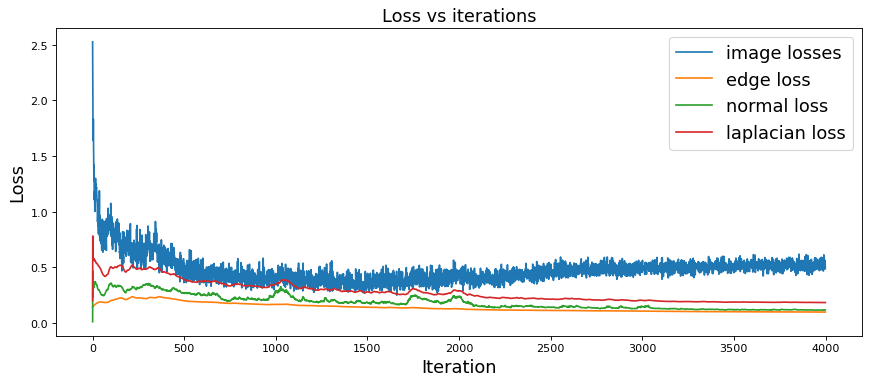

In [ ]:
loss_image = loss_image

fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot([x*w_image for x in image_losses], label="image losses")
ax.plot([x*w_edge for x in edge_losses], label="edge loss")
ax.plot([x*w_normal for x in normal_losses], label="normal loss")
ax.plot([x*w_laplacian for x in laplacian_losses], label="laplacian loss")                                                                                                                                  
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

In [ ]:
plot_batch_individually(new_src_mesh)

Text(0.5, 1.0, 'Loss vs iterations')

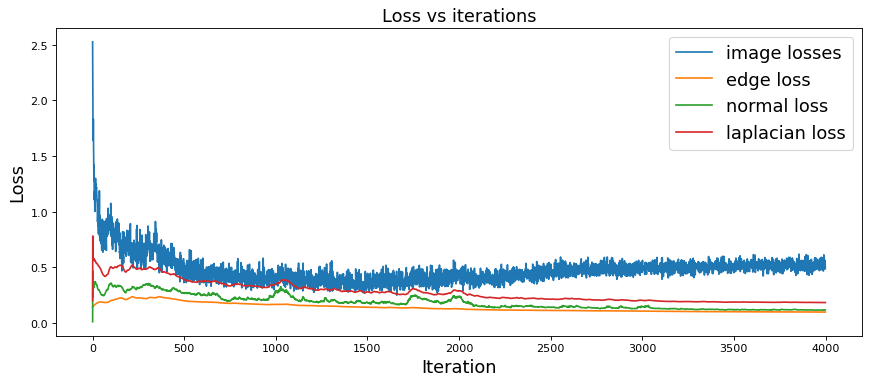

In [ ]:
loss_image = loss_image

fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot([x*w_image for x in image_losses], label="image losses")
ax.plot([x*w_edge for x in edge_losses], label="edge loss")
ax.plot([x*w_normal for x in normal_losses], label="normal loss")
ax.plot([x*w_laplacian for x in laplacian_losses], label="laplacian loss")                                                                                                                                  
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

In [ ]:
verts = new_src_mesh.verts_packed()
faces = new_src_mesh.faces_packed()

save_obj('./inverse_result/mesh_inverse/result_mesh2.obj', verts, faces)

/tmp/ipykernel_3049782/3945741548.py:23: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



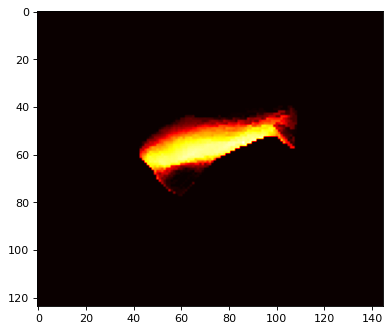

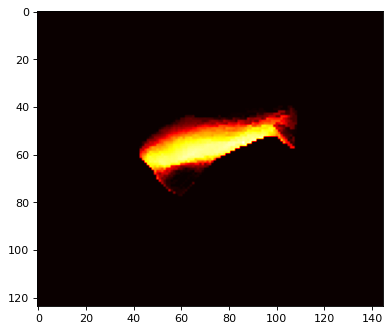

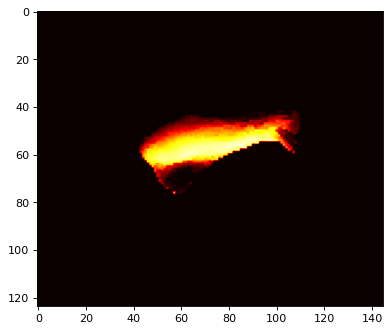

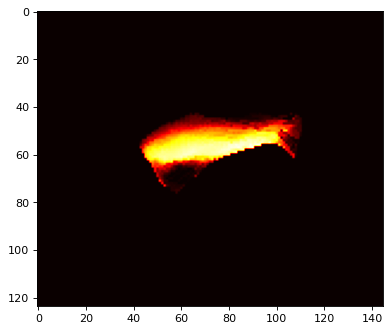

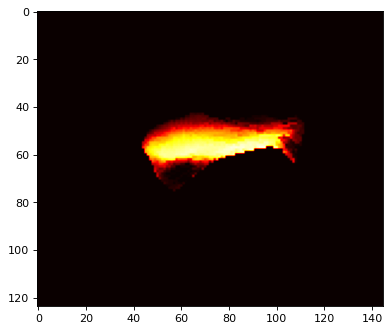

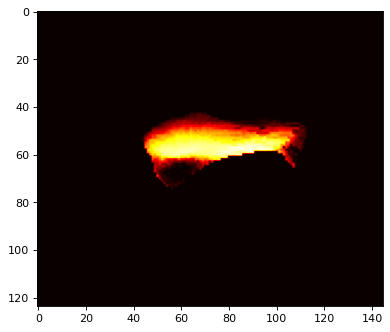

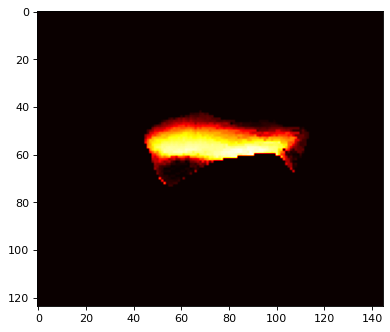

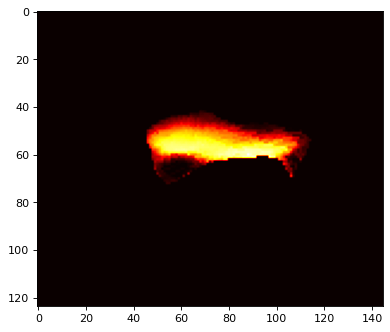

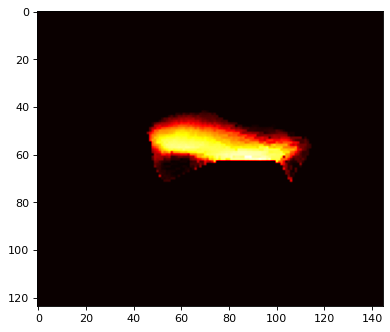

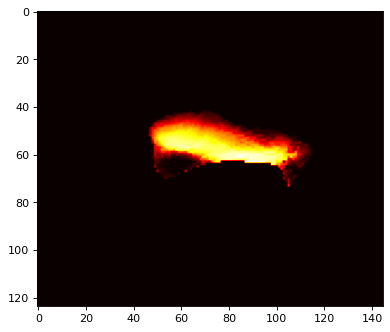

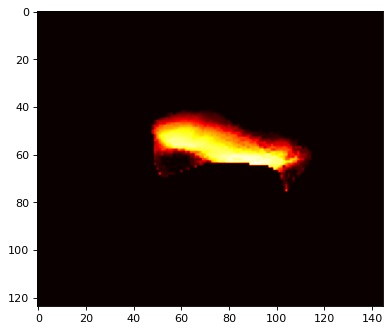

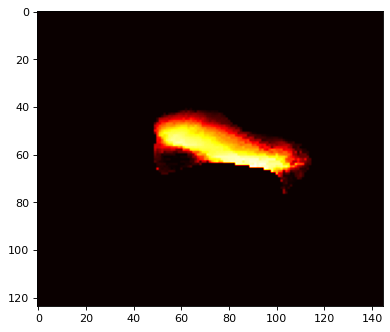

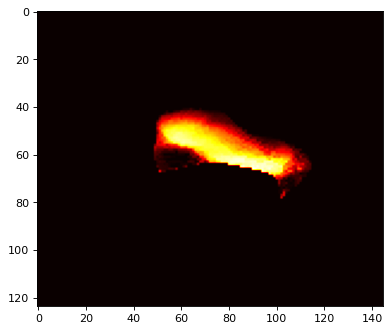

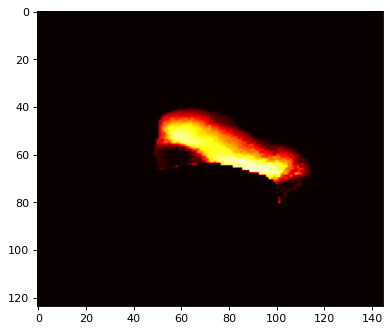

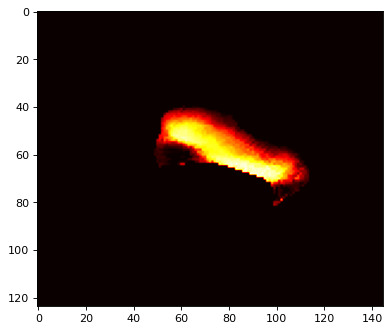

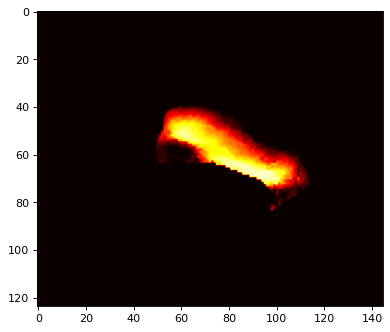

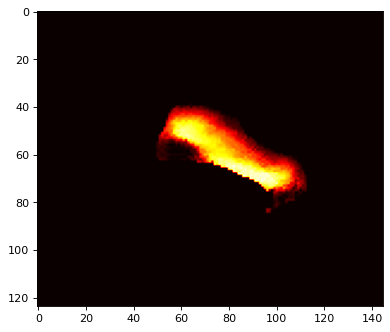

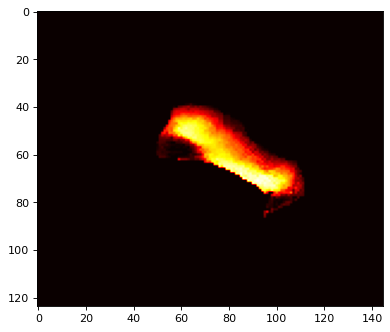

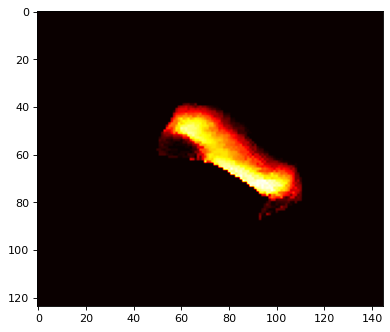

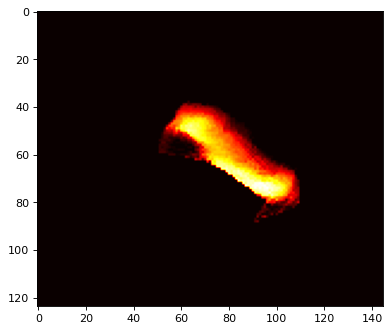

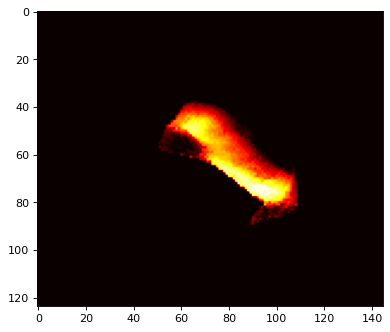

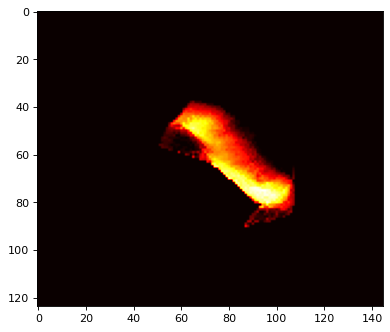

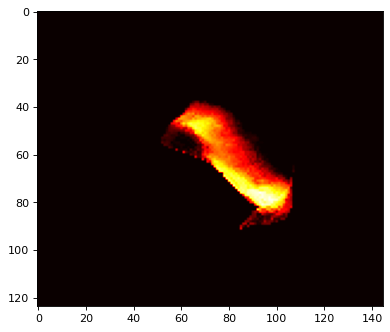

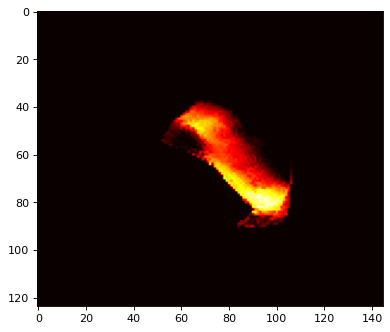

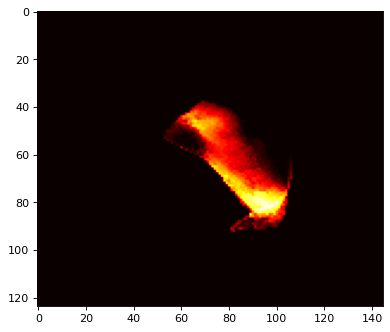

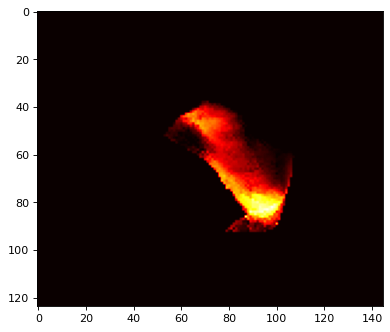

In [ ]:
from torchvision import transforms
from PIL import Image
import os

Meshes_new = visible_mesh1(new_src_mesh,radarele[0:1],radarazi[0:1])
image_src = mesh_radar_render1(Meshes_new,imageele[0:1],imageazi[0:1],radar_vec[0:1,:],omage_vec[0:1,:],omega,dopplercoefficient)     
# 取模归一化
image_src = torch.abs(image_src)
max1,_ = torch.max(image_src,dim=2)
max2,_ = torch.max(max1,dim=1)
image_src = image_src/max2.unsqueeze(1).unsqueeze(2)
plt.figure()
plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
for i in range(25):
    Meshes_new = visible_mesh1(new_src_mesh,radarele[i:i+1],radarazi[i:i+1])
    image_src = mesh_radar_render1(Meshes_new,imageele[i:i+1],imageazi[i:i+1],radar_vec[i:i+1,:],omage_vec[i:i+1,:],omega,dopplercoefficient)     
    image_src = torch.abs(image_src)
    max1,_ = torch.max(image_src,dim=2)
    max2,_ = torch.max(max1,dim=1)
    image_src = image_src/max2.unsqueeze(1).unsqueeze(2)
    image_save = image_src[0,:,:].detach().cpu()

    plt.figure()
    plt.imshow(image_save,cmap='hot')  

    array = image_save.squeeze(0).numpy() * 255  # 转换为数组并缩放到 0-255 范围
    array = array.astype('uint8')  # 将类型转换为 8 位整数

    # 创建一个 PIL 图片对象
    image = Image.fromarray(array, mode='L')  # 'L' 模式表示灰度图像

    # 确定保存路径
    output_folder = './inverse_result/mesh_inverse/result2'
    image_name = 'image' + str(i) + '.png'
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, image_name)

    # 保存图片
    image.save(output_path)